## Getis ord con Pysal

### 1. Preparar los datos
Asumiendo que tienes una tabla df con las siguientes columnas:
- postal_code: Código postal.
- positivity_rate: Tasa de positividad ajustada por la población de mascotas. Para conseguir este número, hay que sumar todos los casos positivos y strong positive de un mismo CP y luego dividir por la estimación de la población de mascotas de ese CP (esto es una posible normalización)
- geometry: Geometría de los códigos postales en formato de polígonos (esto se puede obtener con geopandas).


In [ ]:
# imports
%load_ext autoreload
%autoreload 2

import pandas as pd

import geopandas as gpd
from libpysal.weights import DistanceBand

from esda import G_Local
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))
from main import show_map


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os
print(os.getcwd())

c:\Users\pablo\mascotas\ModeloPrediccionMascotas\ModeloPrediccionMascotas\scripts


In [10]:
df = pd.read_csv("../data/processed/processed_data.csv", dtype={'Postal code': str})
#df = pd.read_csv("../data/new_data.csv", dtype={'Postal code': str})

# fitler to get two columns
df = df[['Value test', 'Postal code']]

print(df.head(1))

   Value test Postal code
0           0        8520


In [11]:
# load postal codes shapefile to get polygon
gdf_postal_info = gpd.read_file("../data/codigos_postales/codigos_postales.shp")
gdf_postal_info = gdf_postal_info.rename(columns={'COD_POSTAL': 'Postal code'})
gdf_postal_info = gdf_postal_info[['Postal code', 'geometry']]
print(gdf_postal_info.head(1))
print(gdf_postal_info.crs)

  Postal code                                           geometry
0       01193  POLYGON ((-2.5306 42.81828, -2.53061 42.81814,...
None


In [12]:
# Contar el número total de resultados y positivos por código postal
positive_rate_df = (
    df.assign(is_positive = lambda x: x['Value test'] == 1)  # Crear una columna booleana
    .groupby('Postal code')  # Agrupar por código postal
    .agg(total_cases = ('Value test', 'size'),  # Total de casos
         positive_cases = ('is_positive', 'sum'))  # Total de casos positivos
    .assign(positivity_rate = lambda x: x['positive_cases'] / x['total_cases'] * 100)  # Calcular porcentaje
)

# Mostrar el resultado
print(positive_rate_df)

             total_cases  positive_cases  positivity_rate
Postal code                                              
10002                  1               0         0.000000
10004                  2               0         0.000000
10005                 96              28        29.166667
1002                  30               5        16.666667
1004                   2               1        50.000000
...                  ...             ...              ...
9006                  18               1         5.555556
9007                  62               1         1.612903
9400                   3               0         0.000000
9500                   7               1        14.285714
9550                   1               0         0.000000

[1215 rows x 3 columns]


In [13]:
# merge both dataframes to work with df
df_merged = pd.merge(positive_rate_df, gdf_postal_info, on='Postal code', how='left')

print(df_merged.head())

  Postal code  total_cases  positive_cases  positivity_rate  \
0       10002            1               0         0.000000   
1       10004            2               0         0.000000   
2       10005           96              28        29.166667   
3        1002           30               5        16.666667   
4        1004            2               1        50.000000   

                                            geometry  
0  POLYGON ((-6.37465 39.47253, -6.37461 39.47232...  
1  POLYGON ((-6.3422 39.59341, -6.34096 39.59319,...  
2  POLYGON ((-6.52977 39.5703, -6.52739 39.56934,...  
3                                               None  
4                                               None  


### 2. Crear la Matriz de Ponderación Espacial
Para crear una matriz de ponderación espacial, puedes definir los vecinos por distancia usando un umbral específico (por ejemplo, 5 km). PySAL proporciona métodos para generar esta matriz de adyacencia.

In [14]:
# Cargar los datos en un GeoDataFrame
gdf = gpd.GeoDataFrame(df_merged, geometry='geometry', crs="EPSG:4326")
gdf = gdf.to_crs("EPSG:25830")

gdf = gdf[gdf.is_valid]

# Crear la matriz de ponderación basada en una distancia de 5 km (ajustable)
w = DistanceBand.from_dataframe(gdf, threshold=5000, binary=True)
w.transform = 'r' # normalize

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 12, ' is an island (no neighbors)')
('WARNING: ', 19, ' is an island (no neighbors)')
('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING: ', 21, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 27, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 31, ' is an island (no neighbors)')
('WARNING: ', 37, ' is an island (no neighbors)')
('WARNING: ', 38, ' is an island (no neighbors)')
('WARNING: ', 41, ' is an island (no neighbors)')
('WARNING: ', 42, ' is an island (no neighbors)')
('WAR

c:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 552 disconnected components.
 There are 432 islands with ids: 0, 1, 2, 8, 9, 10, 11, 12, 19, 20, 21, 22, 23, 27, 30, 31, 37, 38, 41, 42, 43, 44, 45, 49, 50, 52, 53, 56, 57, 58, 62, 63, 64, 65, 66, 67, 73, 74, 75, 76, 77, 78, 79, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 107, 109, 111, 112, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 142, 149, 150, 152, 153, 154, 160, 167, 171, 172, 173, 174, 175, 178, 185, 186, 202, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 226, 244, 274, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 290, 291, 292, 293, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 317, 318, 319, 320, 324, 325, 332, 334, 335, 336, 337, 339, 344, 345, 346, 347, 348, 350, 351

In [15]:
print("Número de observaciones en el GeoDataFrame:", len(gdf))
print("Número de elementos en la matriz de ponderación:", len(w.data))

Número de observaciones en el GeoDataFrame: 1193
Número de elementos en la matriz de ponderación: 1193


### 3. Calcular el Estadístico Getis-Ord Gi*
Una vez que tienes la matriz de ponderación (w) y la variable positivity_rate, puedes usar esda.G de PySAL para calcular el estadístico.

In [16]:
# Calculate Getis-Ord Gi*
g = G_Local(gdf['positivity_rate'], w)

# Obtain z-values y p-values
z_values = g.Zs  # Array with z-value
p_values = g.p_sim  # Array with p-value

c:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\esda\getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
c:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\esda\getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


### 4. Interpretación de Resultados

Los arrays z_values y p_values ahora contienen el valor Z y el valor p para cada código postal en el orden de los datos originales:
- Los valores Z positivos significativos (por ejemplo, con ) indican puntos calientes.
- Los valores Z negativos significativos (también con ) indican puntos fríos.

In [17]:
# Agregar los resultados al GeoDataFrame
gdf['z_value'] = z_values
gdf['p_value'] = p_values

### 5. Visualizacion
Con los resultados en el GeoDataFrame, puedes crear un mapa de coropletas para visualizar los puntos calientes y fríos.

In [20]:
# Filtrar puntos calientes y fríos significativos
gdf['hotspot'] = np.where((gdf['z_value'] > 0) & (gdf['p_value'] < 0.05), 'Hotspot',
                          np.where((gdf['z_value'] < 0) & (gdf['p_value'] < 0.05), 'Coldspot', 'Not Significant'))

show_map(gdf)

Postal code          0
total_cases          0
positive_cases       0
positivity_rate      0
geometry             0
z_value            432
p_value              0
hotspot              0
dtype: int64


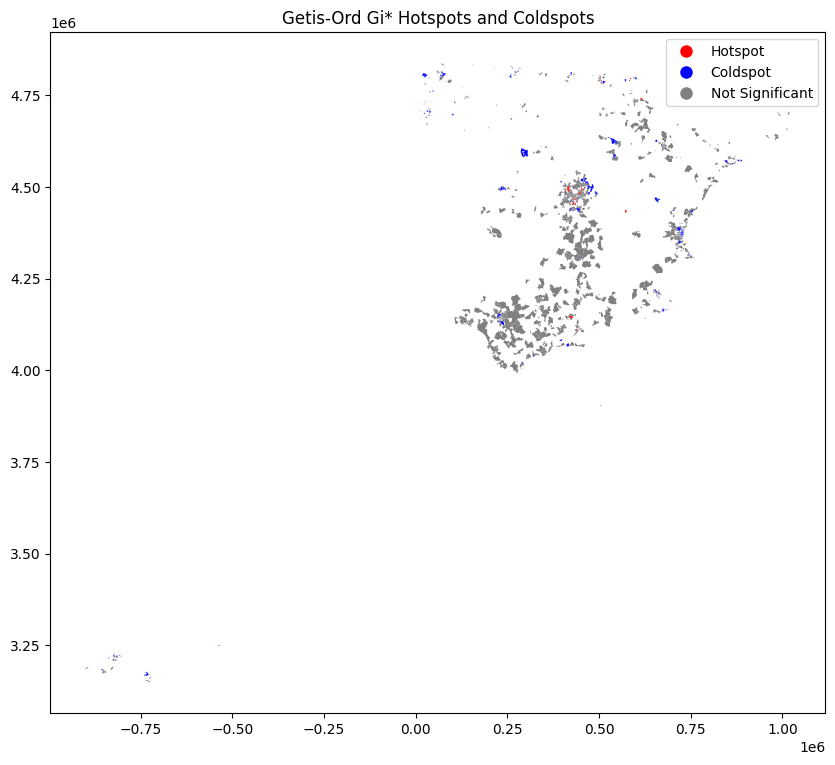

In [19]:


nan_counts = gdf.isna().sum()

# Mostrar el número de NaN por columna
print(nan_counts)

# Crear un mapeo de colores personalizado
colors = ['red', 'blue', 'gray']  # Hotspot: rojo, Coldspot: azul, Not Significant: gris
cmap = ListedColormap(colors)

# Asignar un índice a cada categoría
hotspot_categories = {'Hotspot': 0, 'Coldspot': 1, 'Not Significant': 2}
gdf['hotspot_code'] = gdf['hotspot'].map(hotspot_categories)

# Visualización
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='hotspot_code', cmap=cmap, legend=False, ax=ax)

# Añadir una leyenda personalizada
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Hotspot'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Coldspot'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Not Significant')
]
ax.legend(handles=legend_elements, loc='upper right')

# Título del gráfico
plt.title("Getis-Ord Gi* Hotspots and Coldspots")
plt.show()